In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
"""
!apt install p7zip
!apt install p7zip-full
!pip install pyunpack
!pip install patool

!7za e /kaggle/input/cifar-10/test.7z
!p7zip -d /kaggle/input/cifar-10/test.7z
"""

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.datasets import cifar10

import numpy as np
import matplotlib.pyplot as plt
import cv2

In [ ]:
def show_results(results):
    plt.gcf().set_size_inches(20,5)
    plt.subplot(121)
    plt.plot(results.history["acc"],label="Train")
    plt.plot(results.history["val_acc"],label="Test")
    plt.title("Accuracy")
    plt.legend()
    plt.subplot(122)
    plt.plot(results.history["loss"],label="Train")
    plt.plot(results.history["val_loss"],label="Test")
    plt.title("Loss")
    plt.legend()
    plt.show()
    
def plot_model(history): 
    fig, axs = plt.subplots(1,2,figsize=(16,5)) 
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy'], 'c') 
    axs[0].plot(history.history['val_accuracy'],'m') 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss'], 'c') 
    axs[1].plot(history.history['val_loss'], 'm') 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper right')
    plt.show()

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
y_labels = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
num_classes = len(set(y_train.flatten()))
print("number of classes:", num_classes,"\n=>",y_labels)
print("Train\t", x_train.shape, y_train.shape, "\nTest\t", x_test.shape, y_test.shape)

y_train_onehot = keras.utils.to_categorical(y_train)
y_test_onehot = keras.utils.to_categorical(y_test)
x_train_normalized = x_train.astype('float32')/255
x_test_normalized = x_test.astype('float32')/255

In [ ]:
sample_count = 8
fig_size = 5
fig, ax = plt.subplots(sample_count,sample_count)
fig.set_size_inches((fig_size*sample_count,fig_size*sample_count))
for i in range(sample_count):
    for j in range(sample_count):
        index = i * sample_count + j
        ax[i][j].imshow(cv2.resize(x_train[index],(256,256)))
        ax[i][j].set_title(f"Sample {index}: {y_labels[int(y_train[index])]}") 
print("CIFAR-10 Dataset Samples (resized for human-friendly visualisations)")

### We use input size (32,32,2), same as the researchers experimented (the sobel filtered images has been used)
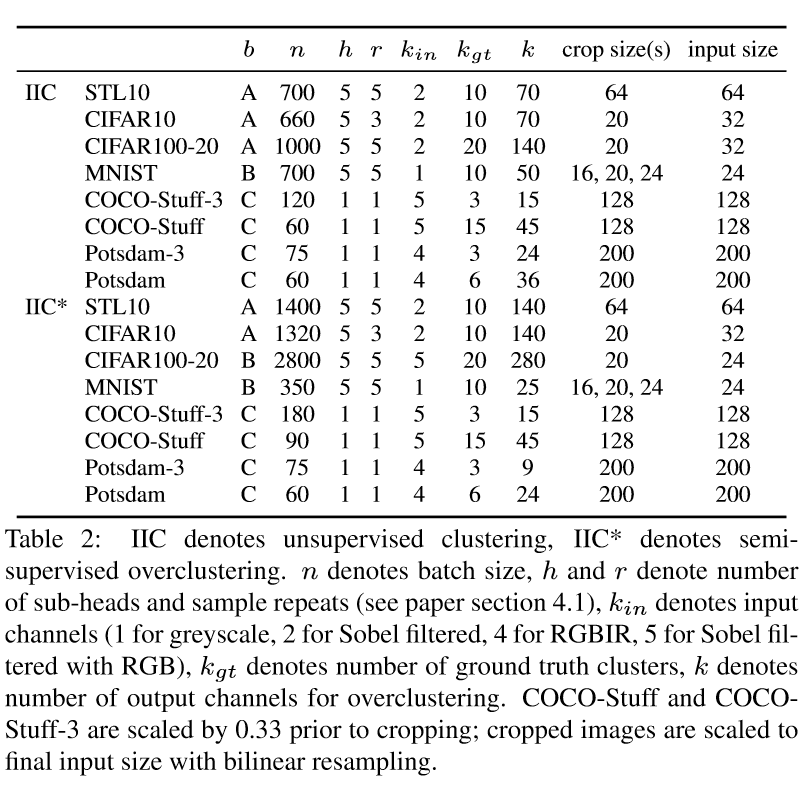 

In [ ]:
def rgb_to_sobel(img):
    sample_image = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(sample_image,cv2.CV_64F,1,0,ksize=5)
    sobely = cv2.Sobel(sample_image,cv2.CV_64F,0,1,ksize=5)
    return cv2.merge([sobelx, sobely])
def rgb_to_laplacian(img):
    sample_image = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    return cv2.Laplacian(sample_image,cv2.CV_64F)

x_train_sobel = np.array([rgb_to_sobel(image) for image in x_train])
x_train_sobel_normalized = np.array([cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F) for image in x_train_sobel])
x_test_sobel = np.array([rgb_to_sobel(image) for image in x_test])
x_test_sobel_normalized = np.array([cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F) for image in x_test_sobel])
x_train_sobel_normalized.shape

Experimenting with sobel filters

In [ ]:
sample_count = 8
fig,ax=plt.subplots(sample_count,10)
fig.set_size_inches(5*10,5*sample_count)

for idx in range(sample_count):
    sample_image = x_train[idx]
    laplacian = rgb_to_laplacian(sample_image)
    sobelx, sobely = cv2.split(rgb_to_sobel(sample_image))
    ax[idx,0].imshow(sample_image)
    ax[idx,1].imshow(cv2.cvtColor(sample_image,cv2.COLOR_RGB2GRAY), cmap=plt.cm.gray)
    ax[idx,2].imshow(laplacian, cmap=plt.cm.gray)
    ax[idx,3].imshow(sobelx, cmap=plt.cm.gray)
    ax[idx,4].imshow(sobely, cmap=plt.cm.gray)
    ax[idx,5].imshow((sobelx+sobely), cmap=plt.cm.gray)
    ax[idx,6].imshow((sobelx*sobely), cmap=plt.cm.gray)
    ax[idx,7].imshow(sobelx*laplacian, cmap=plt.cm.gray)
    ax[idx,8].imshow(sobely*laplacian, cmap=plt.cm.gray)
    ax[idx,9].imshow((sobelx+sobely)*laplacian, cmap=plt.cm.gray)
plt.show()

## In the paper researchers use three different model.
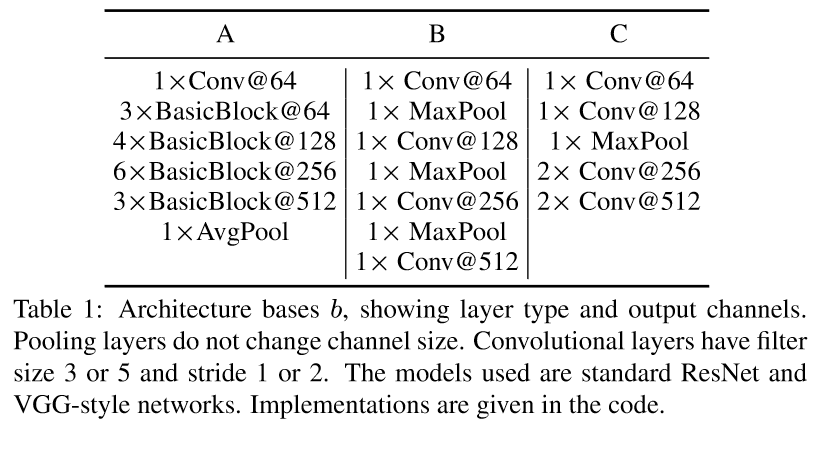
### I will be using the model B (Basically simplified VGGNet)

In [ ]:
model = keras.Sequential()
model.add(keras.layers.InputLayer(input_shape=(32,32,3,)))
model.add(keras.layers.Conv2D(64, (3,3), activation='relu'))
model.add(keras.layers.MaxPool2D((2, 2), padding='same'))
model.add(keras.layers.Conv2D(128, (3,3), activation='relu'))
model.add(keras.layers.MaxPool2D((2, 2), padding='same'))
model.add(keras.layers.Conv2D(256, (3,3), activation='relu'))
model.add(keras.layers.MaxPool2D((2, 2), padding='same'))
model.add(keras.layers.Conv2D(512, (3,3), activation='relu'))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(4096, activation='relu'))
model.add(keras.layers.Dense(4096, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))
model.compile(
    loss='categorical_crossentropy',#'sparse_categorical_crossentropy' , 'mse'
    optimizer=keras.optimizers.Adam(1e-4),#optimizers.RMSprop(lr=1e-4),
    metrics=['acc'])
model.summary()

In [ ]:
supervised_clasification_results = model.fit(
    x_train_normalized,
    y_train_onehot,
    epochs=150,
    batch_size=660,
    shuffle=True,
    validation_data=(x_test_normalized, y_test_onehot)
)

In [ ]:
show_results(supervised_clasification_results)

In [ ]:
# Base CNN Network
CNN = keras.Sequential(name="CNN_Base")
CNN.add(keras.layers.InputLayer(input_shape=(32,32,2,)))
CNN.add(keras.layers.Conv2D(64, (3,3), activation='relu'))
CNN.add(keras.layers.MaxPool2D((2, 2), padding='same'))
CNN.add(keras.layers.Conv2D(128, (3,3), activation='relu'))
CNN.add(keras.layers.MaxPool2D((2, 2), padding='same'))
CNN.add(keras.layers.Conv2D(256, (3,3), activation='relu'))
CNN.add(keras.layers.MaxPool2D((2, 2), padding='same'))
CNN.add(keras.layers.Conv2D(512, (3,3), activation='relu'))
CNN.add(keras.layers.Flatten())
CNN.summary()

# Over-clustering network
HeadA_FC = keras.Sequential(name="Head_A")
HeadA_FC.add(keras.layers.InputLayer(input_shape=CNN.input_shape[1:]))
HeadA_FC.add(CNN)
#HeadA_FC.add(keras.layers.InputLayer(input_shape=CNN.output_shape[1:]))
HeadA_FC.add(keras.layers.Dense(4096, activation='relu'))
HeadA_FC.add(keras.layers.Dense(4096, activation='relu'))
HeadA_FC.add(keras.layers.Dense(70, activation='softmax'))
HeadA_FC.compile(
    loss='categorical_crossentropy',#'sparse_categorical_crossentropy' , 'mse'
    optimizer=keras.optimizers.Adam(1e-4),#optimizers.RMSprop(lr=1e-4),
    metrics=['acc'])
HeadA_FC.summary()

# Semantic-output soft-clustering network
HeadB_FC = keras.Sequential(name="Head_B")
HeadB_FC.add(keras.layers.InputLayer(input_shape=CNN.input_shape[1:]))
HeadB_FC.add(CNN)
#HeadB_FC.add(keras.layers.InputLayer(input_shape=CNN.output_shape[1:]))
HeadB_FC.add(keras.layers.Dense(4096, activation='relu'))
HeadB_FC.add(keras.layers.Dense(4096, activation='relu'))
HeadB_FC.add(keras.layers.Dense(10, activation='softmax'))
HeadB_FC.compile(
    loss='categorical_crossentropy',#'sparse_categorical_crossentropy' , 'mse'
    optimizer=keras.optimizers.Adam(1e-4),#optimizers.RMSprop(lr=1e-4),
    metrics=['acc'])
HeadB_FC.summary()

In [ ]:
results = HeadB_FC.fit(
    x_train_sobel_normalized,
    y_train_onehot,
    epochs=150,
    batch_size=660,
    shuffle=True,
    validation_data=(x_test_sobel_normalized, y_test_onehot)
)

In [ ]:
show_results(results)

In [ ]:
def build_model(lr = 0.001, dc = 1e-5, dr = 0.5, input_shape=(32, 32, 3)):
    model = keras.Sequential(name = 'CNN_cifar10')
    model.add(keras.layers.Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_uniform', kernel_regularizer=keras.regularizers.l2(1e-4), padding='same', input_shape=input_shape))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_uniform', kernel_regularizer=keras.regularizers.l2(1e-4), padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPooling2D((2, 2)))
    model.add(keras.layers.Dropout(0.2))

    model.add(keras.layers.Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_uniform', kernel_regularizer=keras.regularizers.l2(1e-4), padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_uniform', kernel_regularizer=keras.regularizers.l2(1e-4), padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPooling2D((2, 2)))
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_uniform', kernel_regularizer=keras.regularizers.l2(1e-4), padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_uniform', kernel_regularizer=keras.regularizers.l2(1e-4), padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPooling2D((2, 2)))
    model.add(keras.layers.Dropout(0.4))

    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(256, activation='elu', kernel_initializer='he_uniform'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(dr))
    model.add(keras.layers.Dense(10, activation='softmax'))
    # compile model
    opt = keras.optimizers.Adam(lr = lr, decay = dc)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model


model = build_model()
model.summary()

In [ ]:
#data augmentation
datagen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False
    )
datagen.fit(x_train_normalized)

In [ ]:
rlr = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode ='max', factor=0.5, min_lr=1e-7, verbose = 1, patience=10)
es = keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', verbose = 1, patience=50, restore_best_weights=True)
mc = keras.callbacks.ModelCheckpoint('cnn_best_model.h5', monitor='val_accuracy', mode='max', verbose = 1, save_best_only=True)
callback_list = [rlr, es, mc]

# run model
high_acc_results = model.fit_generator(datagen.flow(x_train_normalized, y_train_onehot, batch_size = 64),
                                 validation_data = (x_test_normalized, y_test_onehot),
                                 steps_per_epoch = x_train.shape[0] // 64, 
                                 epochs = 40, verbose = 1,
                                 callbacks = callback_list)

In [ ]:
plot_model(high_acc_results)

In [ ]:
saved_model = load_model('cnn_best_model.h5')
test_loss, test_acc = saved_model.evaluate(X_test, y_test_cat, verbose=0)
print('Test Accuracy:', round(test_acc, 2))

In [ ]:
y_pred = saved_model.predict_classes(x_test_normalized, verbose=0)
y_pred = [y_labels[i] for i in y_pred]
submissions=pd.DataFrame({"id": list(range(1, len(y_pred)+1)), "label": y_pred})
submissions.to_csv("submission.csv", index=False)

In [ ]:
# autoencoders
# knn
# kmeans
# iic
